## **1. Загрузка и предварительный анализ данных**

In [1]:
# импорт библиотек
from pandas import Series
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [4]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
50319,5691,12JAN2014,GRD,M,46,N,N,0,1,-2.279439,3,70,1,2,90000,1,3,Y,0
43008,66893,15MAR2014,SCH,F,28,N,N,0,0,-1.177225,0,70,1,3,26000,1,3,Y,0
45673,65211,14MAR2014,SCH,M,28,Y,N,0,0,-1.557805,1,40,1,1,50000,1,4,N,0
27759,75279,23MAR2014,SCH,M,38,Y,N,0,0,-1.270104,4,60,1,2,30000,1,3,N,1
50302,63059,12MAR2014,UGR,F,26,Y,N,0,0,-0.876236,3,40,1,2,30000,1,3,N,1


In [5]:
test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
4525,12473,20JAN2014,SCH,F,53,Y,N,0,1,-2.637376,0,50,2,3,30000,4,1,N
27959,99507,16APR2014,SCH,M,24,N,N,0,0,-2.253907,1,50,2,3,20000,2,1,N
12250,69403,18MAR2014,SCH,F,31,N,N,0,0,-2.326917,0,40,2,3,15000,2,3,N
25609,76351,24MAR2014,SCH,F,61,N,N,0,0,-2.156347,3,40,1,2,19000,1,3,N
19889,52974,01MAR2014,SCH,M,58,N,N,0,0,-2.432671,0,40,1,1,25000,3,3,N


In [6]:
sample_submission.sample(5)

,client_id,default
22937,28318,0.551959
10665,21636,0.523003
1011,12516,0.855557
7121,107849,0.838257
23412,36861,0.015016


In [7]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [8]:
test.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

### **Описания исходных признаков:**  

  **client_id** - идентификатор клиента  
  **education** - уровень образования  
  **sex** - пол заемщика  
  **age** - возраст заемщика  
  **car** - флаг наличия автомобиля  
  **car_type** - флаг автомобиля иномарки  
  **decline_app_cnt** - количество отказанных прошлых заявок  
  **good_work** - флаг наличия “хорошей” работы  
  **bki_request_cnt** - количество запросов в БКИ  
  **home_address** - категоризатор домашнего адреса  
  **work_address** - категоризатор рабочего адреса  
  **income** - доход заемщика  
  **foreign_passport** - наличие загранпаспорта  
  **sna** - связь заемщика с клиентами банка  
  **first_time** - давность наличия информации о заемщике  
  **score_bki** - скоринговый балл по данным из БКИ  
  **region_rating** - рейтинг региона  
  **app_date** - дата подачи заявки  
  **default** - флаг дефолта по кредиту

### **Анализ распределения определяемой переменной**

In [9]:
# обучающая выборка несбалансирована - использовать accuracy в метрике - некорректно
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

### **Анализ пустых значений в датасете train**

In [10]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [11]:
# информация по колонкам датасета train
#train.info()
#print()
print('Размер датасета train: ', train.shape)

Размер датасета train:  (73799, 19)


In [12]:
# смотрим количество пропусков в датасете train
train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [13]:
# Заполним наиболее встречающимися данными:
item_to_fill_train = train[train['education'].isnull()==False].education.value_counts().index[0]
train.fillna(item_to_fill_train, inplace = True)

# train.isnull().sum()
#train.education.unique()

### **Анализ пустых значений в датасете test**

In [14]:
#test.info()
#print()
print('Размер датасета test: ', test.shape)

Размер датасета test:  (36349, 18)


In [15]:
test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [16]:
# Заполним наиболее встречающимися данными:
item_to_fill_test = test[test['education'].isnull()==False].education.value_counts().index[0]
test.fillna(item_to_fill_test, inplace = True)

#test.isnull().sum()
#test.education.unique()

#### **Исходные признаки датасетов train и test сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего более удобного анализа**

In [17]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # 
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time'] # 
num_cols = ['age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt',  'region_rating', 'income'] # 

#### **Анализ и преобразование признака app_date**

In [18]:
train['app_date'] = train.app_date.apply(pd.Timestamp)
test['app_date'] = test.app_date.apply(pd.Timestamp)

In [19]:
# генерируем новые признаки по app_date: 
# 1. разница между текущей датой и самой ранней заявкой днях может иметь значение, 
# если после определенной даты стали более жесткие требования на выдачу кредита
train_app_date_min = train['app_date'].min()
test_app_date_min = test['app_date'].min()

train['delta_days'] = (train['app_date'] - train_app_date_min).dt.days
test['delta_days'] = (test['app_date'] - test_app_date_min).dt.days

num_cols.append('delta_days')  # добавляем к списку с числовыми признаками

In [20]:
## генерируем новые признаки по app_date: день недели может иметь значение - 
## в определенные дни недели (ex: среда) могут выдавать чаще, чем в другие (ex: в понедельник)
train['day_week'] = train['app_date'].dt.weekday
test['day_week'] = test['app_date'].dt.weekday

cat_cols.append('day_week')  # добавляем к списку с категориальными признаками

In [21]:
# выделение признака 1 - будний день, 0 - выходной день
train['is_weekdays'] = train['day_week'].apply(
    lambda x: 1 if x not in (5, 6) else 0)
test['is_weekdays'] = test['day_week'].apply(
    lambda x: 1 if x not in (5, 6) else 0)

bin_cols.append('is_weekdays')  # добавляем к списку с бинарными признаками

In [22]:
# генерируем новые признаки по app_date: месяц может иметь значение - категориальный признак
train['month_num'] = train['app_date'].dt.month
test['month_num'] = test['app_date'].dt.month

cat_cols.append('month_num') # добавляем к списку с категориальными признаками

#### **Анализ и преобразование численных признаков**

In [23]:
def new_num_feat(data_train, data_test, feat_cat, feat_num):
    """
    Функция создания нового числового признака: 
    среднее значение feat_num в зависимости кат-го призн. feat_cat
    """
    for data in [data_train, data_test]:
        dict_data = dict(data.groupby(feat_cat)[feat_num].mean())
        data[feat_num[:5] + '_mean_' + feat_cat[:5]
            ] = data[feat_cat].apply(lambda x: dict_data[x])
    
    num_cols.append(feat_num[:5] + '_mean_' + feat_cat[:5])
    return data

In [24]:
def new_log_num_feat(data_train, data_test, feat_cat, feat_num):
    """
    Функция создания нового числового признака: 
    среднее значение feat_num в зависимости кат-го призн. feat_cat
    """
    for data in [data_train, data_test]:
        dict_data = dict(data.groupby(feat_cat)[feat_num].mean())
        data['log_' + feat_num[:5] + '_mean_' + feat_cat[:5]
            ] = np.log(4+data[feat_cat].apply(lambda x: dict_data[x]))
    
    num_cols.append('log_' + feat_num[:5] + '_mean_' + feat_cat[:5])
    return data

In [25]:
new_num_feat(train, test, 'education', 'income')
new_num_feat(train, test, 'work_address', 'income')
new_log_num_feat(train, test, 'region_rating', 'bki_request_cnt')
print()

Нижеприведенные новые признаки **ухудшают** оценочную метрику (установлено методом проб)
- новый числовой признак: среднее значение score_bki в зависимости от education 
- новый числовой признак: среднее значение score_bki в зависимости от дня недели 
- новый числовой признак: среднее значение income в зависимости от home_address 
- новый числовой признак: среднее значение income в зависимости от sna 
- новый числовой признак: среднее значение income в зависимости от first_time 
- новый числовой признак: среднее значение region_rating в зависимости от education  
Также не принимались в рассмотрение новые числовые признаки, у которых прослеживалась сильная корреляция с имеющимися числовыми признаками

## **2. Работа с числовыми переменными**

### **2а. Визуализация**

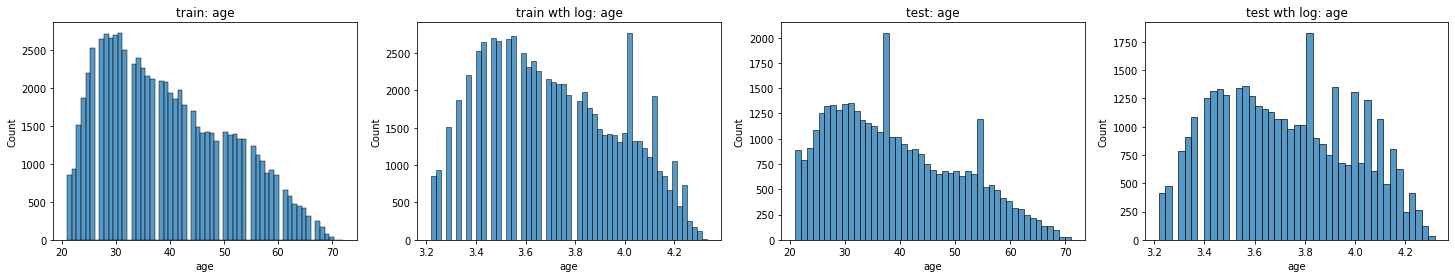

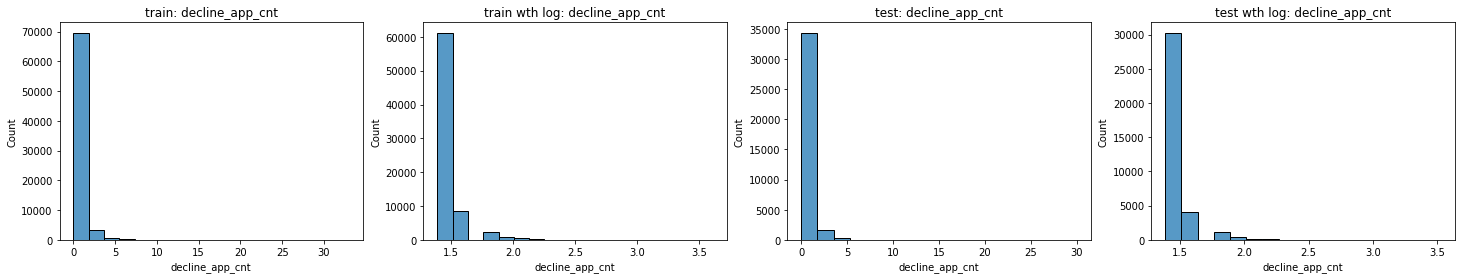

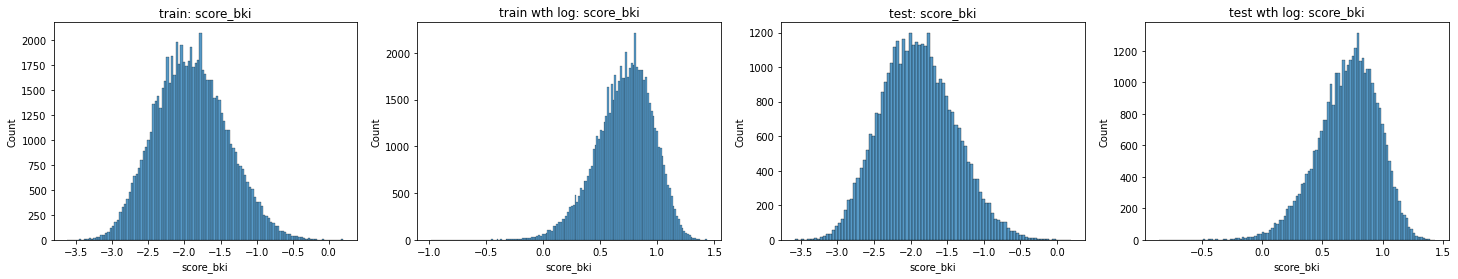

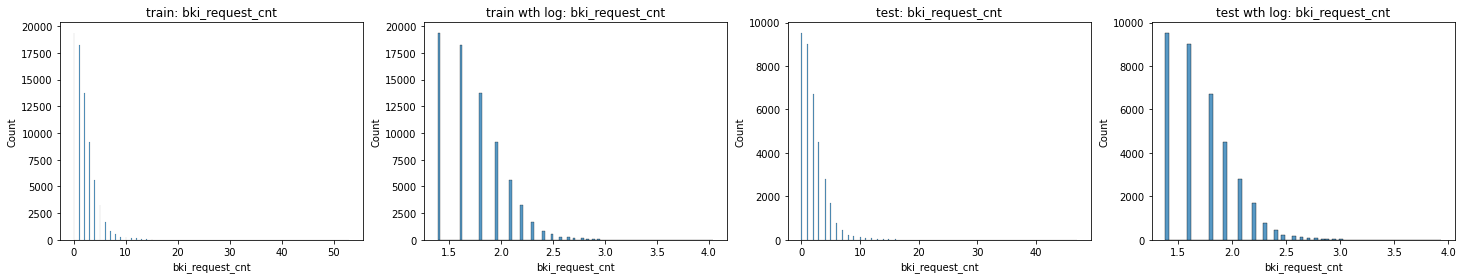

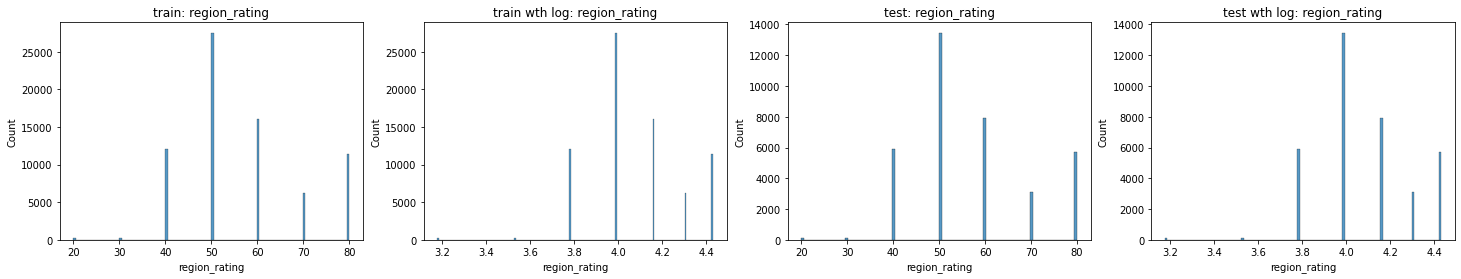

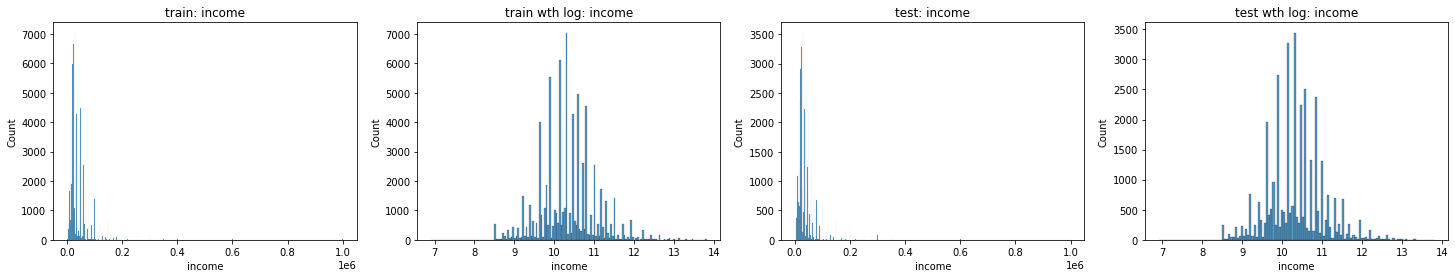

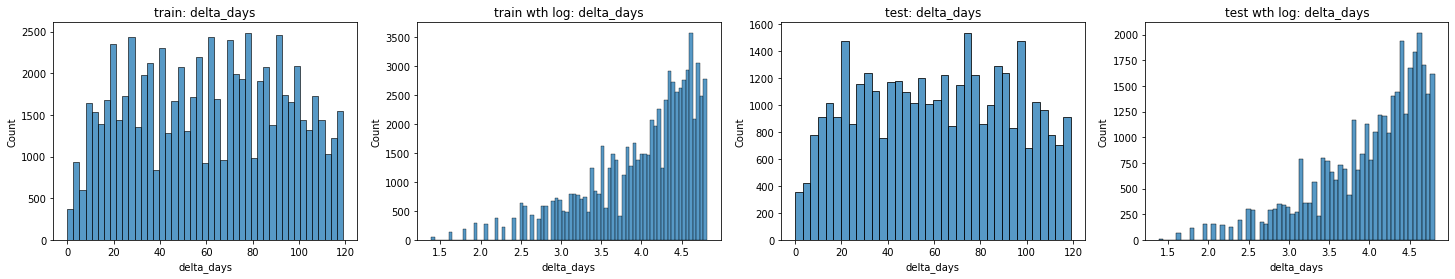

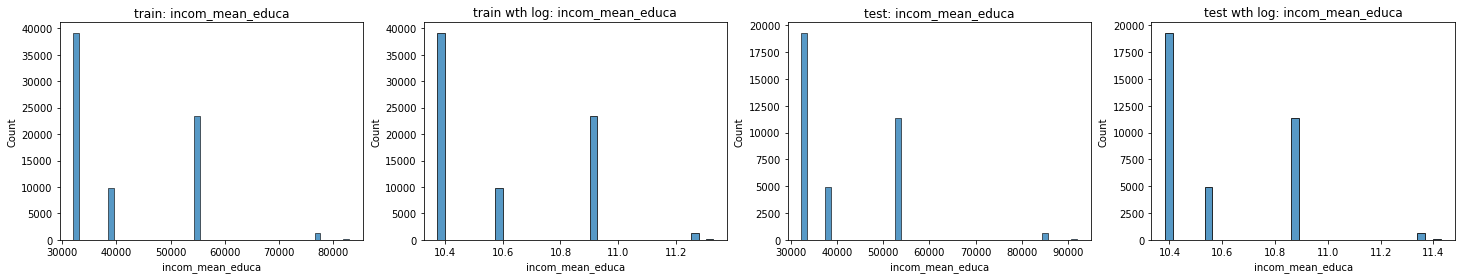

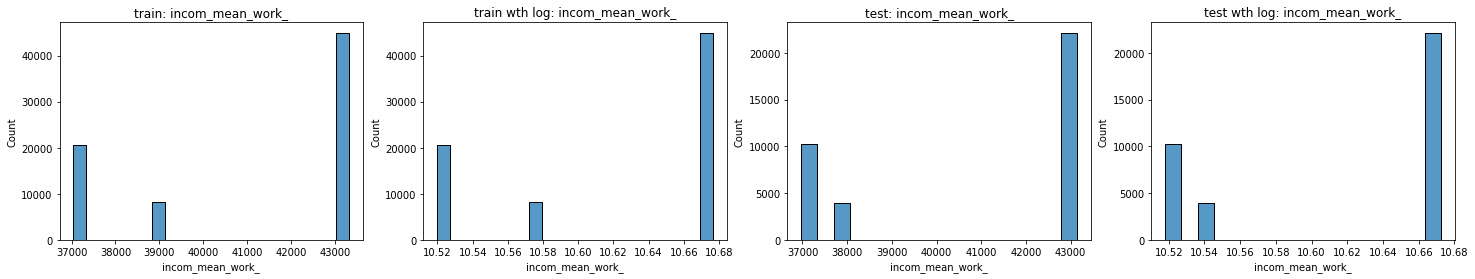

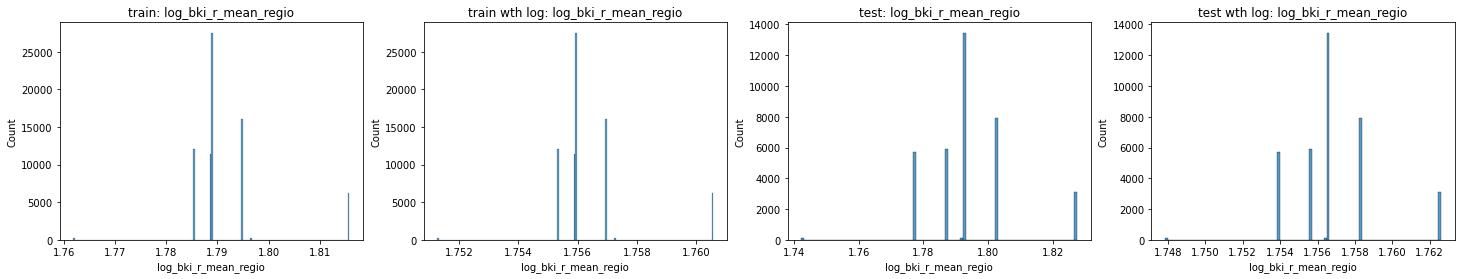

In [26]:
# Посмотрим на распределение числовых данных:
for i in num_cols:
    f, ax = plt.subplots(figsize=(25, 4))
    
    # тренировочная выборка исх данные
    plt.subplot(1, 4, 1)
    sns.histplot(train[i])
    plt.title('train: ' + i)
    
    # тренировочная выборка после логарифмирования
    plt.subplot(1, 4, 2)
    sns.histplot(np.log(4+train[i]))
    plt.title('train wth log: ' + i)
    
    # валидационная выборка исх данные
    plt.subplot(1, 4, 3)
    sns.histplot(test[i])
    plt.title('test: ' + i)
       
    # валидационная выборка ипосле логарифмирования
    plt.subplot(1, 4, 4)
    sns.histplot(np.log(4+test[i]))
    plt.title('test wth log: ' + i)
    plt.show()

#### **Предварительные выводы по гистограммам числовых переменных на исходных признаках в датасетах train и test:**
1. В тренировочной выборке по признаку **age** есть пропуски, их отсуствие может повлиять на предсказание значений в валидационной (test) выборке.
2. В валидационнной (test) выборке по признаку **age** есть выбросы.
3. Признак **score_bki** имеет похожее на нормальное распределение и отрицательно
4. Логарифмирование можно применить для признаков **'decline_app_cnt', 'bki_request_cnt',  'income'** - уменьшаем длину хвоста и приводим к нормальному виду (income)

#### **Посмотрим на распределения boxplot’ов для численных переменных и дефолтных клиентов (default) тренировочной выборки:**

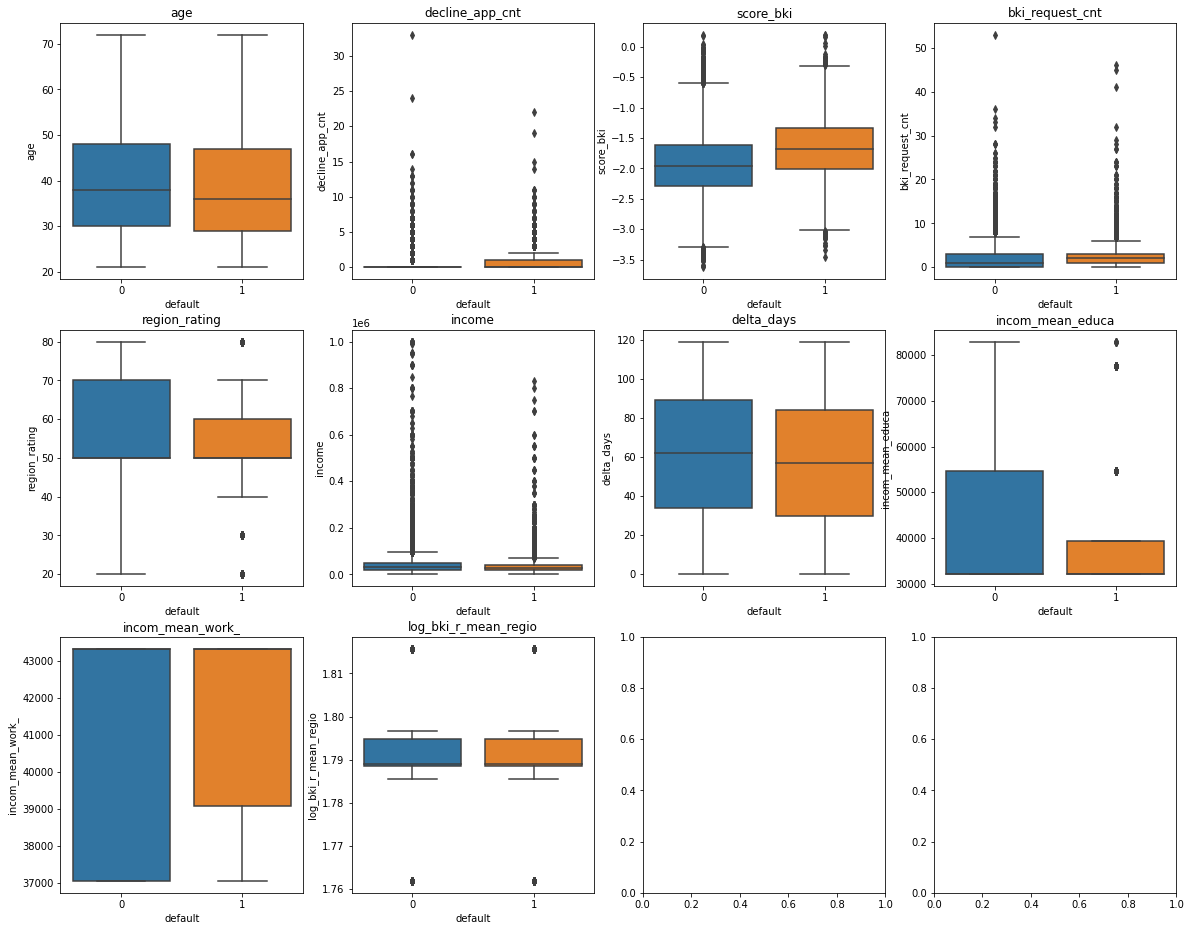

In [27]:
f, ax = plt.subplots(nrows=math.ceil(len(num_cols)/4), 
                     ncols=4, figsize=(20, 16))
for n,i in enumerate(num_cols, start=1):
    plt.subplot(math.ceil(len(num_cols)/4), 4, n)
    sns.boxplot(x="default", y=i, data=train)
    plt.title(i)

plt.show()

In [28]:
train[train.default==0].region_rating.mean(), train[train.default==1].region_rating.mean()

(57.16904403433343, 53.67797695262484)

#### **Предварительные выводы по boxplot’ам для исходных признаках в датасете train**
Прим.: Дефолтные клиенты - default=1
1. Дефолтные клиенты в среднем младше
2. Дефолтные клиенты в среднем имеют большее количество отмененных заявок. 
3. Дефолтные клиенты в среднем имеют более меньший по модулю score_bki
4. Дефолтные клиенты в среднем имеют больше запросов в БКИ
5. Дефолтные клиенты в среднем имеют более низкий рейтинг региона.
6. Дефолтные клиенты в среднем имеют более низкий доход.
7. Дефолтные клиенты в среднем подавали заявку раньше, чем недефолтные.  
Прим.: Новые признаки были созданы после проведенного анализа и не описываются

### **2b. Оценка корреляций**

<AxesSubplot:>

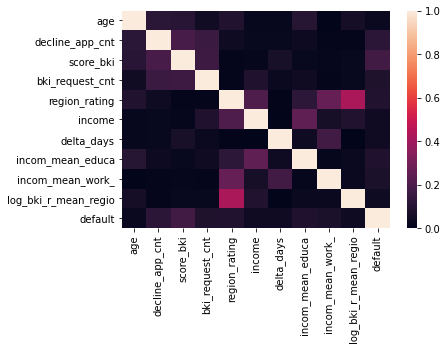

In [29]:
# Оценим корреляцию (корр Пирсона)
sns.heatmap(train[num_cols+['default']].corr().abs(), vmin=0, vmax=1)

In [30]:
train[num_cols+['default']].corr()

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,delta_days,incom_mean_educa,incom_mean_work_,log_bki_r_mean_regio,default
age,1.000000,-0.111175,-0.106275,0.046265,-0.089501,-0.018900,0.015676,-0.105129,0.003847,-0.056548,-0.025004
decline_app_cnt,-0.111175,1.000000,0.189987,0.155894,-0.038505,-0.021687,-0.021352,-0.034331,0.009470,-0.010112,0.113682
score_bki,-0.106275,0.189987,1.000000,0.156257,0.008959,-0.012639,-0.063605,-0.022670,0.012777,0.021943,0.175369
bki_request_cnt,0.046265,0.155894,0.156257,1.000000,0.009025,0.082983,-0.029165,0.039173,0.009791,0.021598,0.078242
region_rating,-0.089501,-0.038505,0.008959,0.009025,1.000000,0.205674,0.007125,0.119368,0.264012,0.418895,-0.089035
income,-0.018900,-0.021687,-0.012639,0.082983,0.205674,1.000000,-0.000454,0.246263,0.061473,0.087903,-0.039752
delta_days,0.015676,-0.021352,-0.063605,-0.029165,0.007125,-0.000454,1.000000,0.035286,0.174452,-0.001127,-0.039372
incom_mean_educa,-0.105129,-0.034331,-0.022670,0.039173,0.119368,0.246263,0.035286,1.000000,0.012421,0.026561,-0.084435
incom_mean_work_,0.003847,0.009470,0.012777,0.009791,0.264012,0.061473,0.174452,0.012421,1.000000,0.027603,0.072038
log_bki_r_mean_regio,-0.056548,-0.010112,0.021943,0.021598,0.418895,0.087903,-0.001127,0.026561,0.027603,1.000000,-0.037749


#### **Выводы по корреляции числовых признаков: числовые признаки слабо скоррелированы между собой**

### **2c. Значимость непрерывных числовых переменных**

<AxesSubplot:>

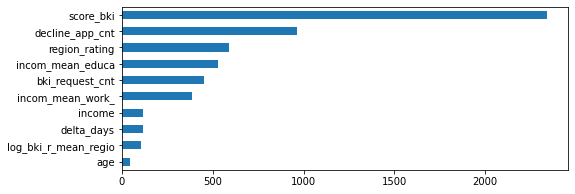

In [31]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], 
                    index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', 
             figsize=(8, np.round(len(imp_num)/3, 0)))

#### **Логарифмирование признаков 'decline_app_cnt', 'bki_request_cnt',  'income'**

In [32]:
train[['decline_app_cnt', 'bki_request_cnt', 'income']] = np.log(1+train[['decline_app_cnt', 
                                                                          'bki_request_cnt',  
                                                                          'income']])

test[['decline_app_cnt', 'bki_request_cnt', 'income']] = np.log(1+test[['decline_app_cnt', 
                                                                        'bki_request_cnt',  
                                                                        'income']])

#### **Выводы по значимости непрерывных переменных: самая значимая числовая переменная для default - score_bki**

## **3. Категориальные переменные**

#### **Создание новых категориальных признаков**


In [33]:
# конъюнкция двух категориальных признаков
def make_conj_2(data, feature_1, feature_2):
    label_encoder = LabelEncoder()
    data[feature_1 + ' + ' + 
         feature_2] = data[feature_1].astype(str) + ' + ' + data[feature_2].astype(str)
    data[feature_1 + ' + ' + 
         feature_2] = label_encoder.fit_transform(data[feature_1 + ' + ' + feature_2])
    return(data)

In [34]:
import itertools
variants = list(itertools.combinations(cat_cols, 2))

for item in variants:
    make_conj_2(train, item[0], item[1])
    make_conj_2(test, item[0], item[1])
    cat_cols.append(item[0] + ' + ' + item[1])

In [35]:
train.shape

(73799, 47)

### **3а. Преобразование категориальных переменных к численным значениям**

In [36]:
# Для бинарных признаков train для преобразования к численным значениям используем LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address + sna,work_address + first_time,work_address + day_week,work_address + month_num,sna + first_time,sna + day_week,sna + month_num,first_time + day_week,first_time + month_num,day_week + month_num
0,25905,2014-02-01,SCH,1,62,1,1,0.000000,0,-2.008753,...,7,4,12,5,12,26,13,5,1,21
1,63161,2014-03-12,SCH,0,59,0,0,0.000000,0,-1.532276,...,11,8,16,10,12,23,14,2,2,10
2,25887,2014-02-01,SCH,1,25,1,0,1.098612,0,-1.408142,...,4,7,12,5,3,5,1,26,13,21
3,16222,2014-01-23,SCH,0,53,0,0,0.000000,0,-2.057471,...,8,10,17,8,2,3,0,17,8,12
4,101655,2014-04-18,GRD,1,48,0,0,0.000000,1,-1.244723,...,8,11,18,11,3,4,3,25,15,19


In [37]:
# Для бинарных признаков validation для преобразования к численным значениям используем LabelEncoder
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
    
# убедимся в преобразовании    
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address + sna,work_address + first_time,work_address + day_week,work_address + month_num,sna + first_time,sna + day_week,sna + month_num,first_time + day_week,first_time + month_num,day_week + month_num
0,74835,2014-03-22,GRD,1,29,1,1,0.000000,0,-2.271884,...,4,7,12,6,3,5,2,26,14,22
1,17527,2014-01-24,SCH,0,39,0,0,1.791759,0,-1.504999,...,7,6,11,4,14,25,12,18,8,16
2,75683,2014-03-23,UGR,1,50,1,1,0.000000,0,-1.691339,...,4,6,13,6,2,6,2,20,10,26
3,26883,2014-02-03,SCH,1,56,0,0,0.000000,0,-2.374182,...,4,6,7,5,2,0,1,14,9,1
4,28862,2014-02-04,GRD,0,38,0,0,0.000000,0,-2.487502,...,8,10,15,9,2,1,1,15,9,5


### **3b. Значимость категориальных переменных**

Для оценки значимости категориальных и бинарных переменных - функция **mutual_info_classif** из библиотеки **sklearn**  
(Прим.: 1. Непараметрические методы, основанные на оценке энтропии в группах категориальных переменных; 2. **mutual_info_classif** сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями.

In [38]:
# преобразуем education к целочисленным значениям через LabelEncoder т.к. уникальные значения 
# для education в train и validation данные одинаковые и новые уникальные значения не предполагаются.
train['education'] = label_encoder.fit_transform(train['education'])
test['education'] = label_encoder.fit_transform(test['education'])

<AxesSubplot:>

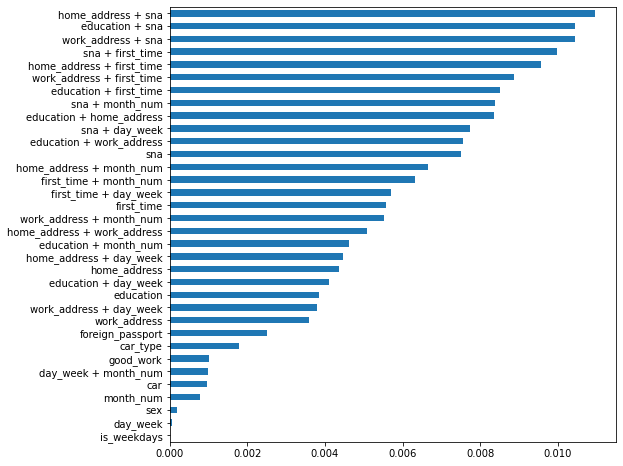

In [39]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], 
                                     train['default'], discrete_features=True), 
                 index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', figsize=(8, np.round(len(imp_cat)/4, 0)))

## **4. Подготовка данных к машинному обучению**

In [40]:
# dummy-кодирование для категориальных переменных
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train[list(set(cat_cols)-
                                                                     set(['education', 'sna']))].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[list(set(cat_cols)-
                                                                   set(['education', 'sna']))].values)
X_cat_train.shape, X_cat_test.shape

# исключаем из OneHotEncoder признаки ['education', 'sna'], т.к. оставим их, как ординальные переменные

((73799, 401), (36349, 401))

In [41]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(train[num_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values) 


#std_scaler = StandardScaler()
#std_scaler.fit(train[num_cols].values)
#X_num_train = std_scaler.transform(train[num_cols].values)
#X_num_test = std_scaler.transform(test[num_cols].values)

In [42]:
# Объединяем стандартизованные числовые, бинарные и закодированные категориальные переменные 
# в одно признаковое пространство
# данные для тренировки модели:
X = np.hstack([X_num_train, train[bin_cols].values, 
               X_cat_train, train[['education', 'sna']].values]) 

# валидационные (не тестовые) данные: 
X_val = np.hstack([X_num_test, test[bin_cols].values, 
                   X_cat_test, test[['education', 'sna']].values]) 
Y = train['default'].values

In [43]:
# Разделим данные для обучения (параметры выбраны для проверки решения)
# Примечание: ранее был выбран лучший test_size для параметров модели по умолчанию и 'liblinear'
test_size = 0.27
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, 
                                                    random_state=r_state)

## **5. Обучение модели**

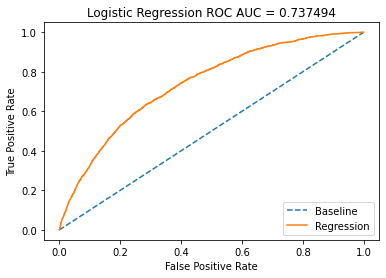

In [44]:
model = LogisticRegression(penalty = 'elasticnet', 
                           solver='saga', 
                           l1_ratio = 0.085, 
                           C=0.006) 

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [45]:
vals = model.predict_proba(X_val)
vals = vals[:,1]

df_submission = pd.DataFrame()
df_submission['client_id'] = test.client_id.values
df_submission['default'] = vals
df_submission.head()

,client_id,default
0,74835,0.046467
1,17527,0.308774
2,75683,0.078301
3,26883,0.088594
4,28862,0.027997


In [46]:
df_submission.to_csv('/kaggle/working/submission.csv', index=False)

df_submission.to_csv('/kaggle/working/best_model_submission.csv', index=False)